# Self study 1

In this self study you should work on the code examples below together with the associated questions. The notebook illustrates a basic neural network implementation, where we implement most of the relevant functions from scratch, except for the calculation of the gradients, for which we rely on the functionality provided by <a urel="https://pytorch.org">PyTorch</a>. 

Since we rely on PyTorch functionality, we will also be using PyTorch's tensor data structure. This data structure operates in much the same way as numpy's ndarrays. You can find a brief introduction to PyTorch's tensors <a href="https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html">here</a>.  



The code illustrates the key concepts involved in the learning neural network. Go carefully through the code before starting to answer the questions at the end.

First we import the modules used in this selfstudy

In [1]:
import torch
from torchvision import datasets, transforms
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np

Through torch load the MNIST data set, which we will use in this self study. The MNIST database consists of grey scale images of handwritten digits. Each image is of size $28\times 28$; see figure below for an illustration. The data set is divided into a training set consisting of $60000$ images and a test set with $10000$ images; in both
data sets the images are labeled with the correct digits. If interested, you can find more information about the MNIST data set at http://yann.lecun.com/exdb/mnist/, including accuracy results for various machine learning methods.

![MNIST DATA](MNIST-dataset.png)

Using the data loader provided by torch we have an easy way of loading in data in batches (here of size 64). We can also make various other transformation of the data, such as normalization. The details for loading the data are not really that important, but if yiu are curious, you can find a quick introduction <a href="https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html">here</a>.

In [44]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=batch_size, shuffle=True)

In the cell above, we are loading data in batches, which is subsequently used during optimization. We didn't discuss batch based learning during the last lecture, but please take a look at Slides 24 and 25 to get the gist of the approach. We will cover it in more detail during the next lecture.   

Each batch is a list of two elements. The first element encodes the digit and has dimensions [64,1,28,28] (the figures are greyscale with no rbg channel, hence the '1'), and the second element contains the class/label information. 

Batch dimension (digit): torch.Size([64, 1, 28, 28])
Batch dimension (target): torch.Size([64])
Target: 9 with shape torch.Size([])


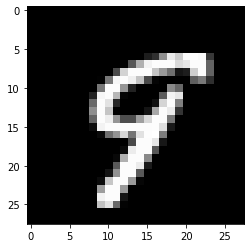

In [45]:
batch = iter(train_loader).next()
print(f"Batch dimension (digit): {batch[0].shape}")
print(f"Batch dimension (target): {batch[1].shape}")
digit_batch = batch[0]
img = digit_batch[0,:]
pyplot.imshow(img.reshape((28, 28)), cmap="gray")
print(f"Target: {batch[1][0]} with shape {batch[1][0].shape}")

With PyTorch we can specify that the tensors require gradients. This will make PyTorch record all operations performed on the tensors, so that we can afterwards calculate the gradients automatically using back propagation. See also the code example from the last lecture.

For the first part of this self study we will specify a neural network, which will encode a softmax function (see, e.g., Page 180 in <a href="https://www.deeplearningbook.org/contents/mlp.html">The Deep Learning book</a>). For this we need a (randomly initialized) weight matrix and a bias, and for both of them we need their gradients wrt. our error function (yet to be defined) in order to perform learning. Note that to facilitate matrix multiplication we will flatten our image from $28\times 28$ to $784$. 

In [55]:
weights = torch.randn(784, 10) / np.sqrt(784)
#weights = torch.randn(784, 10) # no normalization
#weights = torch.zeros(784, 10) # all zeros
# weights = torch.ones(784, 10) / np.sqrt(784) # all ones
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Out model specification

In [47]:
def softmax(x):
    return x.exp() / x.exp().sum(-1).unsqueeze(-1)

def model(xb):
    return softmax(xb @ weights + bias)

Let's test our model (with our randomly initialized weights)

In [48]:
# We flatten the digit representation so that it is consistent with the weight matrix
xb = digit_batch.flatten(start_dim=1)
print(f"Batch shape: {xb.shape}")
preds = model(xb)
print(f"Prediction on first image {preds[0]}")
print(f"Corresponding classification: {preds[0].argmax()}")
print(f"Actual label: {batch[1][0]}")

Batch shape: torch.Size([64, 784])
Prediction on first image tensor([0.0468, 0.1839, 0.1050, 0.0300, 0.0733, 0.1437, 0.0317, 0.0847, 0.0999,
        0.2011], grad_fn=<SelectBackward0>)
Corresponding classification: 9
Actual label: 9


Next we define our loss function, in this case the log-loss (or negative log-likelihood):

In [ ]:
def nll(input, target):
    return (-input[range(target.shape[0]), target].log()).mean() 

def nll_reg(input, target, l2_alpha=None, l1_alpha=None):
    l1_term = 0 
    l2_term = 0
    if l1_alpha:
        l1_term = l1_alpha * (weights.abs().sum())
    if l2_alpha:
        l2_term = (l2_alpha / 2) * (weights.pow(2)).sum()     
    return nll(input, target) + l1_term + l2_term

loss_func = nll_reg

# Make a test calculation
yb = batch[1]
print(loss_func(preds,yb))
# doing softmax+cross entropy given target probability distribution is one-hot it is the same as softmax+nll
preds_no_softmax = xb @ weights + bias
torch.nn.functional.cross_entropy(preds_no_softmax, yb, reduction='mean')

tensor(2.5922, grad_fn=<AddBackward0>)


tensor(2.5922, grad_fn=<NllLossBackward0>)

In the end, we are interested in the accuracy of our model

In [8]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [9]:
print(f"Accuracy of model on batch (with random weights): {accuracy(preds, yb)}")

Accuracy of model on batch (with random weights): 0.0390625


Now we are ready to combine it all and perform learning

In [56]:
epochs = 1  # how many epochs to train for
lr = 0.01  # learning rate
use_mometum = False
alpha = 0.9
l2 = None #0.001
l1 = 0.001
# initialize here or reset per epoch?
v = torch.zeros(weights.shape, requires_grad=False) # momentum 

train_losses = []
for epoch in range(epochs):
    
    for batch_idx, (xb, yb) in enumerate(train_loader):

        xb = xb.squeeze().flatten(start_dim=1)
        pred = model(xb)
        # We specify the loss
        loss = loss_func(pred, yb, l2_alpha=l2, l1_alpha=l1)
        # and perform backpropagation    
        loss.backward()
        # Lastly we update the weights and bias (torch.no_grad() ensures that no gradient 
        # calculations are taking place in this part of the code)
        with torch.no_grad():
            if use_mometum:
                v = alpha * v - lr * weights.grad
                weights += v
            else:
                weights -= lr * weights.grad
            bias -= bias.grad * lr
            
            # After updating we set the gradients to zero so that we are eready for the next round
            weights.grad.zero_()
            bias.grad.zero_()
                    
            if batch_idx % 50 == 0:
                with torch.no_grad():
                    train_loss = np.mean([loss_func(model(txb.squeeze().flatten(start_dim=1)), tyb).item() for txb, tyb in train_loader])
                    print(f"Epoch: {epoch}, B-idx: {batch_idx}, Training loss: {train_loss}")
                    train_losses.append(train_loss)

Epoch: 0, B-idx: 0, Training loss: 2.563682193695101
Epoch: 0, B-idx: 50, Training loss: 0.8513009550093588
Epoch: 0, B-idx: 100, Training loss: 0.639221255204825
Epoch: 0, B-idx: 150, Training loss: 0.553362171977822
Epoch: 0, B-idx: 200, Training loss: 0.5076477492351268
Epoch: 0, B-idx: 250, Training loss: 0.4770060892997266
Epoch: 0, B-idx: 300, Training loss: 0.4574198121868217
Epoch: 0, B-idx: 350, Training loss: 0.4393691544307829
Epoch: 0, B-idx: 400, Training loss: 0.42479008908020155
Epoch: 0, B-idx: 450, Training loss: 0.414039772949112
Epoch: 0, B-idx: 500, Training loss: 0.40593490101444696
Epoch: 0, B-idx: 550, Training loss: 0.39773790071259685
Epoch: 0, B-idx: 600, Training loss: 0.39123347477872233
Epoch: 0, B-idx: 650, Training loss: 0.3861337223731633
Epoch: 0, B-idx: 700, Training loss: 0.38142823615371546
Epoch: 0, B-idx: 750, Training loss: 0.3766162608827609
Epoch: 0, B-idx: 800, Training loss: 0.37384454475473494
Epoch: 0, B-idx: 850, Training loss: 0.3739436185

Plot the evolution of the training loss

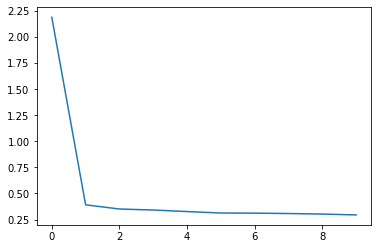

In [66]:
plt.plot(range(len(train_losses)), train_losses)

__Exercise:__ 
1. Experiment with different variations of the gradient descent implementation; try varying the learning rate and the batch size. Assuming that you have a fixed time budget (say 2 minutes for learning), what can we then say about the effect of changing the parameters?
2. Implement momentum in the learning algorithm. How does it affect the results?
3. Try with different initialization schemes for the parameters (e.g. allowing for larger values). How does it affect the behavior of the algorithm?
4. Analyze the behavior of the algorithm on the test set and implement a method for evaluating the accuracy over the entire training/test set.
5. If you feel adventorous, you are welcome to try to specify and experiment with other more advanced model architectures (cell 23). 

__Exc. 1:__ 
1. Experiment with different variations of the gradient descent implementation; try varying the learning rate and the batch size. Assuming that you have a fixed time budget (say 2 minutes for learning), what can we then say about the effect of changing the parameters?

Run 1:
default
- batch_size = 64
- learning_rate = 0.01
- time = 2 min. 25 sec.

<img src="images/loss_1.png" alt="drawing" width="300"/>

Run 2: trying to double batch size and learning rate 
expecting somewhat same graph, as lr / batch_size should be same same proportion
- batch_size = 128
- learning_rate = 0.02
- time = 1 min. 17 sec.

<img src="images/loss_2.png" alt="drawing" width="300"/>

Run 3: smaller lr 
- batch_size = 128
- learning_rate = 0.001
- time = 1 min. 15 sec.

<img src="images/loss_3.png" alt="drawing" width="300"/>

- outcome: slower training or higher loss after 1 epoch, so trying to give it 2 epoch to give it 2 minutes

Now giving 2 epochs:

<img src="images/loss_3_1.png" alt="drawing" width="300"/>

time: 2 min. 58 sec.
Loss drops but not reaching .3

__Exc. 2:__ 

2. Implement momentum in the learning algorithm. How does it affect the results?

using what seems best combination for 2 min.
- batch_size = 128
- learning_rate = 0.02
- epoch = 2 (to give around 2 min.)
without momentum loss gives:

<img src="images/no_loss1.png" alt="drawing" width="300"/>

with momentum loss gives:

<img src="images/mo_loss1.png" alt="drawing" width="300"/>

no material difference in this case, but momemntum got slightly lower loss, and we can see more rapid decrease in loss initially, but has more oscillation later on

__Exc. 3:__

3. Try with different initialization schemes for the parameters (e.g. allowing for larger values). How does it affect the behavior of the algorithm?

- will try the one mentionened in the Michael Nielsen book, that setting std to (1/sqrt(n_input))
  to try to minimize the std of the output of the neurons so as not to have std = sqrt(n_input), which can if using sigmoid activation function as it could saturate the gradient, especially for mse,
  however we are not using the sigmoid, so not a problem in our case

- Aim: can se the above is already default so will try effect of removing / sqrt(784)
- Outcome: gave nan values everywhere, so likely the softmax get overflow, so we must ensure reasonable range for the output of the neurons

- Aim: 0 intialization
- Outcome: worked pretty well

<image src="images/zero_in_loss1.png" width=300/>

- Aim: 1/sqrt(784) intialization
- Outcome: also ok

<image src="images/one_in_loss1.png" width=300/>

__Exc. 4:__

4. Analyze the behavior of the algorithm on the test set and implement a method for evaluating the accuracy over the entire training/test set.

In [75]:
# accuracy + loss function 
def acc_loss(model, data_loader):
    acc = [] 
    loss = []
    with torch.no_grad():
        for xb, yb in data_loader:
            xb = xb.squeeze().flatten(start_dim=1)
            out = model(xb)
            acc.append(accuracy(out, yb))
            loss.append(loss_func(out, yb))
    return np.mean(acc), np.mean(loss)

tr_acc, tr_loss = acc_loss(model, train_loader)
te_acc, te_loss = acc_loss(model, test_loader)

In [76]:
print(f"Training accuracy: {tr_acc}, Training loss: {tr_loss}")
print(f"Testing accuracy: {te_acc}, Testing loss: {te_loss}")

Training accuracy: 0.915012001991272, Training loss: 0.29876306653022766
Testing accuracy: 0.9175237417221069, Testing loss: 0.29211851954460144
